In [13]:
%matplotlib inline
import pandas
import matplotlib
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


# Average window_stride elements together to form a single row
window_stride = 12

sample_hours = window_stride / 12.0
print("Sample Hours: %f" % sample_hours)

# Number of future samples to mean for prediction
prediction_window = int(24 / sample_hours)
print("Prediction Window: %d" % prediction_window)

# Length of the windowed sequence
sequence_length = int(7*24 / sample_hours)
print("Sequence Length: %d" % sequence_length)

# Number of features we take from the data
input_features = 9
num_features = input_features
num_inputs = input_features

# Number of things we are doing regression to predict
num_outputs = 4

# Input Features
columns = ['hour', 'temp', 'windspd', 'winddir', 'no', 'no2', 'nox', 'o3', 'epoch']

# Read the data
df = pandas.read_csv('d00.csv')

# Drop useless columns
df = df.drop(['AQS_Code', 'Latitude', 'Longitude', 'day'], axis=1)

# Unprocessed dataset
nd = df[columns].values

# Windowed dataset
nd_window = np.zeros((int(nd.shape[0] / window_stride), num_inputs))

row = 0
while row < nd.shape[0] - window_stride:
    for i in range(0, input_features):
        nd_window[int(row/window_stride)][i] = np.mean(nd[row:row+window_stride,i])
    row += window_stride
    
scaler = MinMaxScaler()
scaler.fit(nd_window)
nd_window = scaler.transform(nd_window)


# Create sequences
data = []
labels = []


rows = deque(maxlen=sequence_length)

for idx, r in enumerate(nd_window):

    rows.append([a for a in r])
    
    # We need the entire sequence filled to make a prediction about the future mean
    if len(rows) < sequence_length:
        continue
    
    # Since we are predicting the mean, make sure we do not go out of bounds in the future
    if idx+1 + prediction_window > nd_window.shape[0]:
        break
        
    data.append(rows.copy())
        
    # We are predicting the future mean values
    u_24_no = np.mean( nd_window[idx+1 : idx+1 + prediction_window, 4] )
    u_24_no2 = np.mean( nd_window[idx+1 : idx+1 + prediction_window, 5] )
    u_24_nox = np.mean( nd_window[idx+1 : idx+1 + prediction_window, 6] )
    u_24_o3 = np.mean( nd_window[idx+1 : idx+1 + prediction_window, 7] )
    
    labels.append([u_24_no, u_24_no2, u_24_nox, u_24_o3])

data = np.array(data)
labels = np.array(labels)

Sample Hours: 1.000000
Prediction Window: 24
Sequence Length: 168


In [ ]:
from keras.models import Model
from keras import backend as K
from keras.layers import Dense, LSTM, Input, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

layer_input = Input(shape=(sequence_length, input_features), name='inputs')

# For some reason putting some extra dimensions before an LSTM works wonders
dense_1 = Dense(128, input_dim=(sequence_length, input_features))(layer_input)

layer_lstm = LSTM(64, return_sequences=True, dropout=0.5)(dense_1)
layer_flatten = Flatten()(layer_lstm)

layer_output = Dense(num_outputs, activation='linear', name='outputs')(layer_flatten)

model = Model(inputs=[layer_input], outputs=[layer_output])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2])
model.summary()

def sched(epoch, lr):
    new_lr = 0.001 * (0.95 ** epoch)
    print("Epoch(%d) LR: %f" % (epoch+1, new_lr))
    return new_lr

lr_decay = LearningRateScheduler(schedule=sched) 

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tensorboard = TensorBoard(log_dir='./tb', histogram_freq=0, batch_size=128, write_graph=True, write_grads=False)

model.fit(x=data, y=labels, batch_size=128, epochs=100, validation_split=0.2, verbose=True, callbacks=[lr_decay, checkpoint, tensorboard])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 168, 9)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 168, 128)          1280      
_________________________________________________________________
lstm_13 (LSTM)               (None, 168, 64)           49408     
_________________________________________________________________
flatten_12 (Flatten)         (None, 10752)             0         
_________________________________________________________________
outputs (Dense)              (None, 4)                 43012     
Total params: 93,700
Trainable params: 93,700
Non-trainable params: 0
_________________________________________________________________
Train on 6513 samples, validate on 1629 samples
Epoch 1/100
Epoch(1) LR: 0.001000
6513/6513 [==============================] - 15s 2ms/ste

Rendered 0
Rendered 1
Rendered 2
Rendered 3
Rendered 4
Rendered 5
Rendered 6
Rendered 7
Rendered 8
Rendered 9
Rendered 10
Rendered 11
Rendered 12
Rendered 13
Rendered 14
Rendered 15
Rendered 16
Rendered 17
Rendered 18
Rendered 19
Rendered 20
Rendered 21
Rendered 22
Rendered 23
Rendered 24
Rendered 25
Rendered 26
Rendered 27
Rendered 28
Rendered 29
Rendered 30
Rendered 31
Rendered 32
Rendered 33
Rendered 34
Rendered 35
Rendered 36
Rendered 37
Rendered 38
Rendered 39
Rendered 40
Rendered 41
Rendered 42
Rendered 43
Rendered 44
Rendered 45
Rendered 46
Rendered 47
Rendered 48
Rendered 49
Rendered 50
Rendered 51
Rendered 52
Rendered 53
Rendered 54
Rendered 55
Rendered 56
Rendered 57
Rendered 58
Rendered 59
Rendered 60
Rendered 61
Rendered 62
Rendered 63
Rendered 64
Rendered 65
Rendered 66
Rendered 67
Rendered 68
Rendered 69
Rendered 70
Rendered 71
Rendered 72
Rendered 73
Rendered 74
Rendered 75
Rendered 76
Rendered 77
Rendered 78
Rendered 79
Rendered 80
Rendered 81
Rendered 82
Rendered 83
Re

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fc1d8bb3bf8> returned a result with an error set

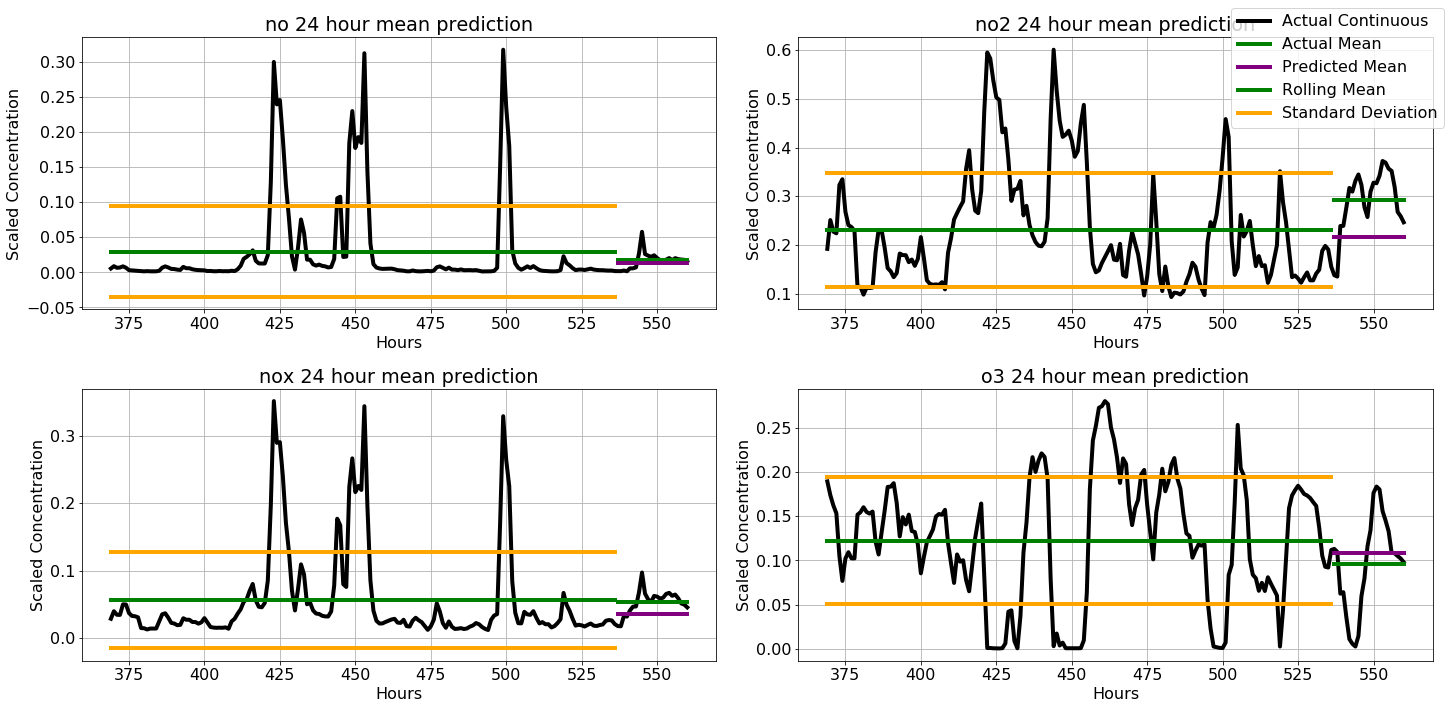

In [3]:
model.load_weights("weights.best.hdf5")

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 16

for seq in range(0, data.shape[0] - sequence_length):
    
    lookup = {'no': (0, 0), 'no2':(0, 1), 'nox':(1, 0), 'o3':(1, 1)}

    pred = model.predict(data[seq].reshape(1, sequence_length, num_features))[0]
    fig, ax = plt.subplots(2, 2)

    for idx,f in enumerate([(4, 'no'), (5, 'no2'), (6, 'nox'), (7, 'o3')]):
    
        feature_index, feature_name = f
        
        X = []
        Y_actual = []

        for i in range(0, sequence_length + int(24*(1/sample_hours))):
            X.append(seq+i)
            Y_actual.append(data[seq+i][-1][feature_index])

        Y_actual = np.array(Y_actual)
        
        predicted_mean = pred[feature_index - 4]
        actual_mean = np.mean(Y_actual[sequence_length:])
        rolling_mean = np.mean(Y_actual[:sequence_length])
        rolling_std = np.std(Y_actual[:sequence_length])
        
        Y_pred = Y_actual.copy()
        Y_pred[sequence_length:] = predicted_mean
        Y_pred[:sequence_length] = np.nan

        Y_actual_mean = Y_actual.copy()
        Y_actual_mean[sequence_length:] = actual_mean
        Y_actual_mean[:sequence_length] = np.nan
        
        Y_rolling_mean = Y_actual.copy()
        Y_rolling_mean[:sequence_length] = rolling_mean
        Y_rolling_mean[sequence_length:] = np.nan
        
        Y_rolling_std_upper = Y_actual.copy()
        Y_rolling_std_upper[:sequence_length] = rolling_mean + rolling_std
        Y_rolling_std_upper[sequence_length:] = np.nan
        
        Y_rolling_std_lower = Y_actual.copy()
        Y_rolling_std_lower[:sequence_length] = rolling_mean - rolling_std
        Y_rolling_std_lower[sequence_length:] = np.nan   
        
        subplot = ax[lookup[feature_name][0]][lookup[feature_name][1]]

        subplot.plot(X, Y_actual, color='black', linewidth=4.0)
        subplot.plot(X, Y_actual_mean, color='green', linewidth=4.0)
        subplot.plot(X, Y_pred, color='purple', linewidth=4.0)
        subplot.plot(X, Y_rolling_mean, color='green', linewidth=4.0)
        subplot.plot(X, Y_rolling_std_upper, color='orange', linewidth=4.0)
        subplot.plot(X, Y_rolling_std_lower, color='orange', linewidth=4.0)
        
        subplot.grid()
        
        subplot.set_title("%s 24 hour mean prediction" % (feature_name,))
        
        subplot.set_xlabel("Hours")
        subplot.set_ylabel("Scaled Concentration")
    
    fig.legend(['Actual Continuous', 'Actual Mean', 'Predicted Mean', 'Rolling Mean', 'Standard Deviation'])
    fig.tight_layout()

    plt.savefig('charts/%.05d.png' % seq)
    # plt.show()
    plt.close()

    print("Rendered %d" % seq)